In [5]:
!python3 -m pip install scikit-learn

In [2]:
!python3 -m site

sys.path = [
    '/home/hai/code/stud_assistant',
    '/home/hai/miniconda3/lib/python312.zip',
    '/home/hai/miniconda3/lib/python3.12',
    '/home/hai/miniconda3/lib/python3.12/lib-dynload',
    '/home/hai/miniconda3/lib/python3.12/site-packages',
]
USER_BASE: '/home/hai/.local' (exists)
USER_SITE: '/home/hai/.local/lib/python3.12/site-packages' (doesn't exist)
ENABLE_USER_SITE: True


In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn import datasets
import ipywidgets as widgets
from ipywidgets import interact

In [12]:

def show_pca(cov_11=3, cov_12=3, cov_21=3, cov_22=4):
    rng = np.random.RandomState(42)
    n_samples = 500
    cov = [[cov_11, cov_12], [cov_21, cov_22]]
    X = rng.multivariate_normal(mean=[0, 0], cov=cov, size=n_samples)
    pca = PCA(n_components=2).fit(X)
    
    
    plt.scatter(X[:, 0], X[:, 1], alpha=0.3, label="samples")
    for i, (comp, var) in enumerate(zip(pca.components_, pca.explained_variance_)):
        comp = comp * var  # scale component by its variance explanation power
        arrow_color = 'green' if i == 0 else 'red'
        plt.arrow(
            0, 0, comp[0], comp[1],
            head_width=0.2, head_length=0.3,
            fc=arrow_color, ec=arrow_color,
            length_includes_head=True,
            label=f"Component {i+1}",
            linewidth=2,
        )
    plt.gca().set(
        aspect="equal",
        title="2-dimensional dataset with principal components",
        xlabel="first feature",
        ylabel="second feature",
    )
    plt.legend()
    plt.show()

interact(show_pca, 
         cov_11=widgets.FloatSlider(value=3, min=-10, max=10, step=1, description='Cov 1 1'),
         cov_12=widgets.FloatSlider(value=3, min=-10, max=10, step=1, description='Cov 1 2'),
         cov_21=widgets.FloatSlider(value=3, min=-10, max=10, step=1, description='Cov 2 1'),
         cov_22=widgets.FloatSlider(value=4, min=-10, max=10, step=1, description='Cov 2 2'),
         )

interactive(children=(FloatSlider(value=3.0, description='Cov 1 1', max=10.0, min=-10.0, step=1.0), FloatSlide…

<function __main__.show_pca(cov_11=3, cov_12=3, cov_21=3, cov_22=4)>

Notes for notebook, remove later:
* show linear models with feature selection (use check boxes)
* show their performances
* show simple pcr and compare to linear regression
* show pls and compare predictive powers

In [13]:
diabetes = datasets.load_diabetes()
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [14]:
diabetes_df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
diabetes_df['target'] = diabetes.target
diabetes_df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


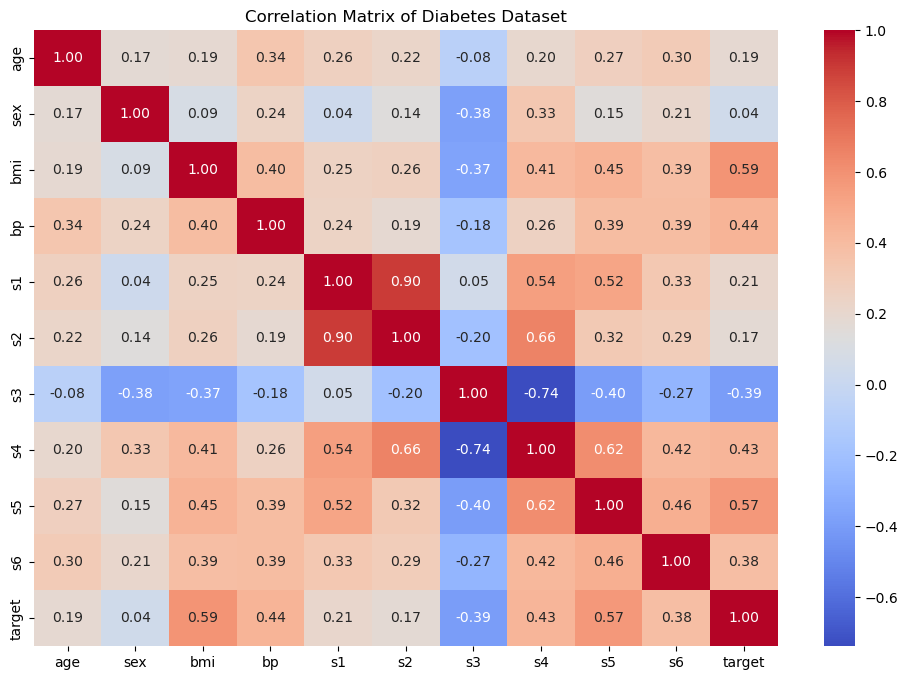

In [15]:
corr_matrix = diabetes_df.corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Diabetes Dataset')
plt.show()